## Cleaning & exploring the data

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import seaborn as sns
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile

api = KaggleApi()
api.authenticate()

dataset_owner = 'brllrb'  
dataset_name = 'uber-and-lyft-dataset-boston-ma'  
file_name = 'rideshare_kaggle.csv'  
zip_file_name = f'{file_name}.zip'  

api.dataset_download_file(f'{dataset_owner}/{dataset_name}', file_name)

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall()

df = pd.read_csv(file_name)

# because the file is too big for github, I'm removing it after loading it in the dataframe

os.remove(zip_file_name)
os.remove(file_name)

Dataset URL: https://www.kaggle.com/datasets/brllrb/uber-and-lyft-dataset-boston-ma


Now that the data is loaded in a dataframe, I will explore it a little bit.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           693071 non-null  object 
 1   timestamp                    693071 non-null  float64
 2   hour                         693071 non-null  int64  
 3   day                          693071 non-null  int64  
 4   month                        693071 non-null  int64  
 5   datetime                     693071 non-null  object 
 6   timezone                     693071 non-null  object 
 7   source                       693071 non-null  object 
 8   destination                  693071 non-null  object 
 9   cab_type                     693071 non-null  object 
 10  product_id                   693071 non-null  object 
 11  name                         693071 non-null  object 
 12  price                        637976 non-null  float64
 13 

We only got missing values in [price] and that's the one I want to predict, so I will drop it.

In [3]:
df = df.dropna(subset=['price'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 637976 entries, 0 to 693070
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           637976 non-null  object 
 1   timestamp                    637976 non-null  float64
 2   hour                         637976 non-null  int64  
 3   day                          637976 non-null  int64  
 4   month                        637976 non-null  int64  
 5   datetime                     637976 non-null  object 
 6   timezone                     637976 non-null  object 
 7   source                       637976 non-null  object 
 8   destination                  637976 non-null  object 
 9   cab_type                     637976 non-null  object 
 10  product_id                   637976 non-null  object 
 11  name                         637976 non-null  object 
 12  price                        637976 non-null  float64
 13  dist

All the other columns seem to be completely filled in. I will drop some columns that I am sure that I won't be using.

In [4]:
df = df.drop(['id', 'timezone', 'icon', 'visibility.1'], axis=1)

On first sight I see some strange values in [product_id]. Can I remove them or do they having something to do with the name or cabtype?

In [5]:
# Check how many times I got strange values

df['product_id'].value_counts()

product_id
9a0e7b09-b92b-4c41-9779-2ad22b4d779d    55096
6d318bcc-22a3-4af6-bddd-b409bfce1546    55096
6f72dfc5-27f1-42e8-84db-ccc7a75f6969    55096
6c84fd89-3f11-4782-9b50-97c468b19529    55095
55c66225-fbe7-4fd5-9072-eab1ece5e23e    55094
997acbb5-e102-41e1-b155-9df7de0a73f2    55091
lyft                                    51235
lyft_premier                            51235
lyft_plus                               51235
lyft_luxsuv                             51235
lyft_lux                                51235
lyft_line                               51233
Name: count, dtype: int64

Too much to ignore, so check with name and cab_type.

In [6]:
df.groupby('product_id')['name'].nunique()

product_id
55c66225-fbe7-4fd5-9072-eab1ece5e23e    1
6c84fd89-3f11-4782-9b50-97c468b19529    1
6d318bcc-22a3-4af6-bddd-b409bfce1546    1
6f72dfc5-27f1-42e8-84db-ccc7a75f6969    1
997acbb5-e102-41e1-b155-9df7de0a73f2    1
9a0e7b09-b92b-4c41-9779-2ad22b4d779d    1
lyft                                    1
lyft_line                               1
lyft_lux                                1
lyft_luxsuv                             1
lyft_plus                               1
lyft_premier                            1
Name: name, dtype: int64

Clear 1-1 relation with the name, so let's see in combination with cab_type

In [7]:
df.groupby(['product_id', 'name'])['cab_type'].nunique()

product_id                            name        
55c66225-fbe7-4fd5-9072-eab1ece5e23e  UberX           1
6c84fd89-3f11-4782-9b50-97c468b19529  Black           1
6d318bcc-22a3-4af6-bddd-b409bfce1546  Black SUV       1
6f72dfc5-27f1-42e8-84db-ccc7a75f6969  UberXL          1
997acbb5-e102-41e1-b155-9df7de0a73f2  UberPool        1
9a0e7b09-b92b-4c41-9779-2ad22b4d779d  WAV             1
lyft                                  Lyft            1
lyft_line                             Shared          1
lyft_lux                              Lux Black       1
lyft_luxsuv                           Lux Black XL    1
lyft_plus                             Lyft XL         1
lyft_premier                          Lux             1
Name: cab_type, dtype: int64

It's clear that we can drop the product_id column

In [8]:
df = df.drop('product_id', axis=1)

I want the day of the week instead of the day of the month. I will take it out datetime and then remove [day]

In [9]:
df['datetime'] = pd.to_datetime(df['datetime'])

df['day_of_week'] = df['datetime'].dt.dayofweek

df = df.drop(['day'], axis=1)

Let's check how the numerical values are distributed.

In [10]:
df.describe()

,timestamp,hour,month,datetime,price,distance,surge_multiplier,latitude,longitude,temperature,...,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,day_of_week
count,6.379760e+05,637976.000000,637976.000000,637976,637976.000000,637976.000000,637976.000000,637976.000000,637976.000000,637976.000000,...,6.379760e+05,637976.000000,6.379760e+05,637976.000000,6.379760e+05,637976.000000,6.379760e+05,637976.000000,6.379760e+05,637976.000000
mean,1.544046e+09,11.618528,11.586550,2018-12-05 21:34:04.918879488,16.545125,2.189261,1.015068,42.338161,-71.066144,39.582406,...,1.544044e+09,33.456171,1.544042e+09,45.259945,1.544047e+09,29.729028,1.544048e+09,41.995876,1.544048e+09,2.781699
min,1.543204e+09,0.000000,11.000000,2018-11-26 03:40:46,2.500000,0.020000,1.000000,42.214800,-71.105400,18.910000,...,1.543162e+09,15.630000,1.543122e+09,33.510000,1.543154e+09,11.810000,1.543136e+09,28.950000,1.543187e+09,0.000000
25%,1.543444e+09,6.000000,11.000000,2018-11-28 22:26:08,9.000000,1.270000,1.000000,42.350300,-71.081000,36.450000,...,1.543421e+09,30.170000,1.543399e+09,42.570000,1.543439e+09,27.760000,1.543399e+09,36.570000,1.543439e+09,1.000000
50%,1.543737e+09,12.000000,12.000000,2018-12-02 07:52:59,13.500000,2.160000,1.000000,42.351900,-71.063100,40.490000,...,1.543770e+09,34.240000,1.543727e+09,44.660000,1.543788e+09,30.130000,1.543745e+09,40.950000,1.543788e+09,3.000000
75%,1.544828e+09,18.000000,12.000000,2018-12-14 22:45:04,22.500000,2.930000,1.000000,42.364700,-71.054200,43.580000,...,1.544807e+09,38.880000,1.544789e+09,46.910000,1.544814e+09,35.710000,1.544789e+09,44.120000,1.544818e+09,5.000000
max,1.545161e+09,23.000000,12.000000,2018-12-18 19:15:10,97.500000,7.860000,3.000000,42.366100,-71.033000,57.220000,...,1.545152e+09,43.100000,1.545192e+09,57.870000,1.545109e+09,40.050000,1.545134e+09,57.200000,1.545109e+09,6.000000
std,6.892028e+05,6.948776,0.492452,NaN,9.324359,1.135413,0.095422,0.047856,0.020303,6.725500,...,6.912268e+05,6.466349,6.902087e+05,5.644414,6.901597e+05,7.109907,6.872011e+05,6.935538,6.911036e+05,2.056670


I will be making some histograms to visualize them. But this will not be needed for numerical values that are actually rather categorical, like hour, timestamp, etc.

In [11]:
df.select_dtypes(include=[np.number]).columns

Index(['timestamp', 'hour', 'month', 'price', 'distance', 'surge_multiplier',
       'latitude', 'longitude', 'temperature', 'apparentTemperature',
       'precipIntensity', 'precipProbability', 'humidity', 'windSpeed',
       'windGust', 'windGustTime', 'visibility', 'temperatureHigh',
       'temperatureHighTime', 'temperatureLow', 'temperatureLowTime',
       'apparentTemperatureHigh', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureLowTime', 'dewPoint',
       'pressure', 'windBearing', 'cloudCover', 'uvIndex', 'ozone',
       'sunriseTime', 'sunsetTime', 'moonPhase', 'precipIntensityMax',
       'uvIndexTime', 'temperatureMin', 'temperatureMinTime', 'temperatureMax',
       'temperatureMaxTime', 'apparentTemperatureMin',
       'apparentTemperatureMinTime', 'apparentTemperatureMax',
       'apparentTemperatureMaxTime', 'day_of_week'],
      dtype='object')

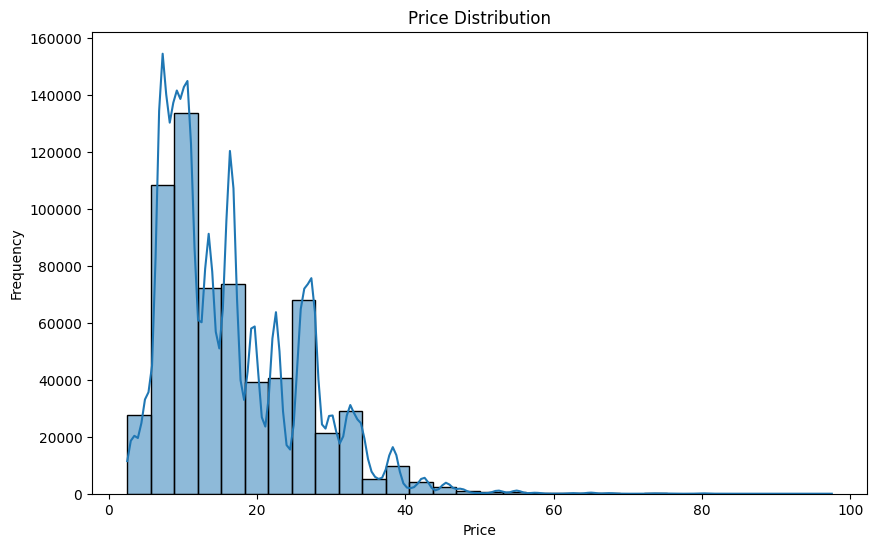

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=30, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

Right skewed, so I will apply a log transformation on [price] - Because it is my target variable, I can apply this before splitting.

In [13]:
df['price_log'] = np.log1p(df['price'])

<Axes: xlabel='price_log', ylabel='Count'>

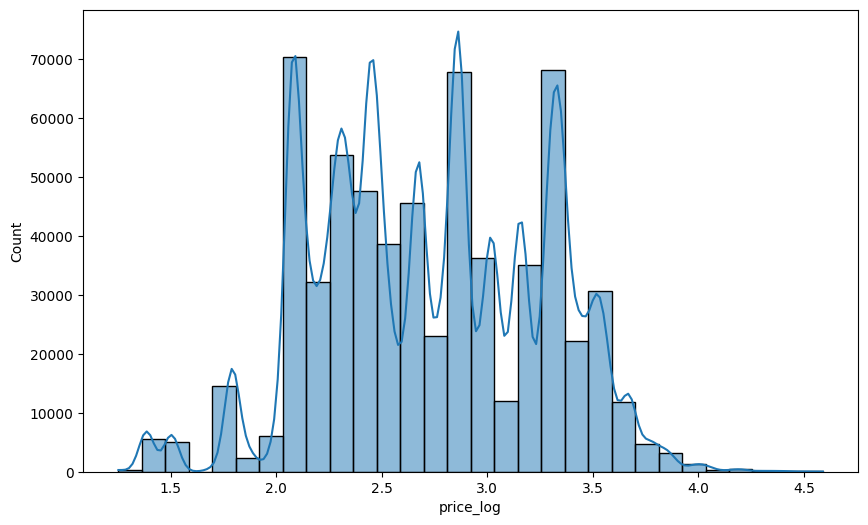

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price_log'], bins=30, kde=True)

Plotting [distance]

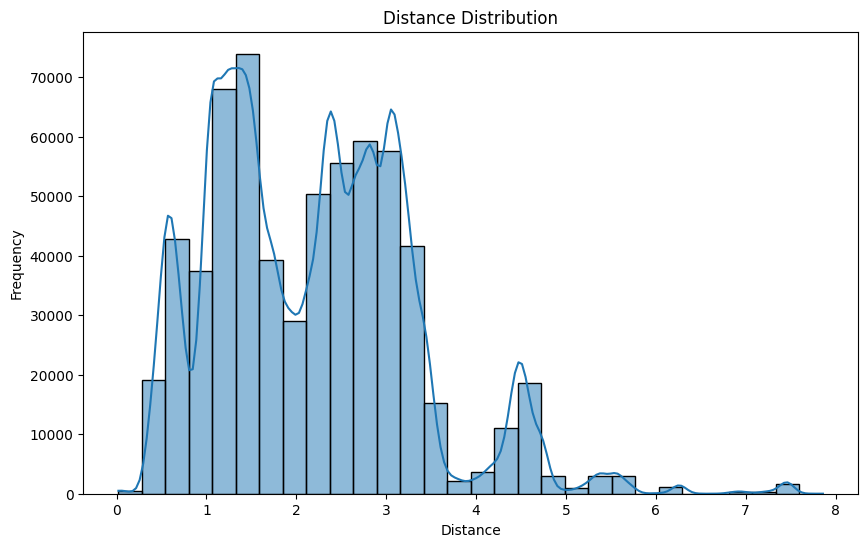

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(df['distance'], bins=30, kde=True)
plt.title('Distance Distribution')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

Not so much skewness, so I will just apply standardscaler afterwards in the pipeline. Now the next one:

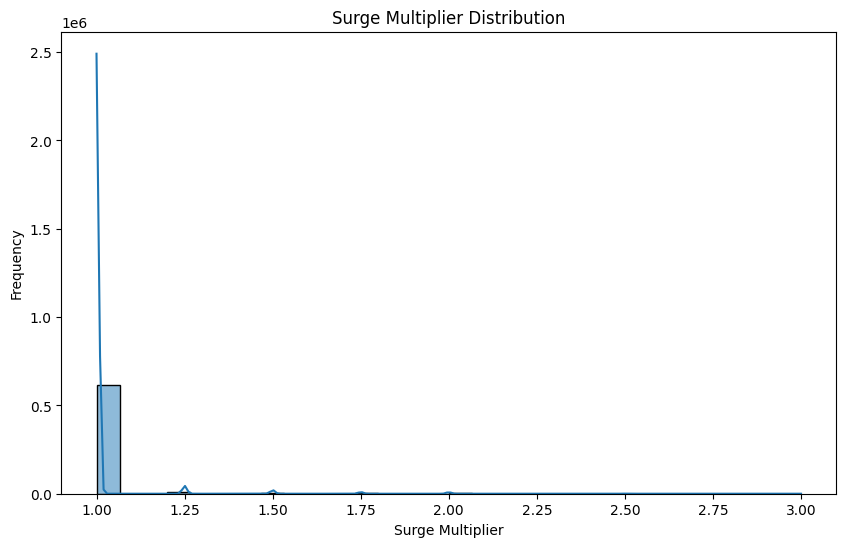

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(df['surge_multiplier'], bins=30, kde=True)
plt.title('Surge Multiplier Distribution')
plt.xlabel('Surge Multiplier')
plt.ylabel('Frequency')
plt.show()

It looks to me that it's better to put those into categories, so I convert this column to an object.

In [ ]:
df['surge_multiplier'] = df['surge_multiplier'].astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 637976 entries, 0 to 693070
Data columns (total 53 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   timestamp                    637976 non-null  float64       
 1   hour                         637976 non-null  int64         
 2   month                        637976 non-null  int64         
 3   datetime                     637976 non-null  datetime64[ns]
 4   source                       637976 non-null  object        
 5   destination                  637976 non-null  object        
 6   cab_type                     637976 non-null  object        
 7   name                         637976 non-null  object        
 8   price                        637976 non-null  float64       
 9   distance                     637976 non-null  float64       
 10  surge_multiplier             637976 non-null  object        
 11  latitude                     63

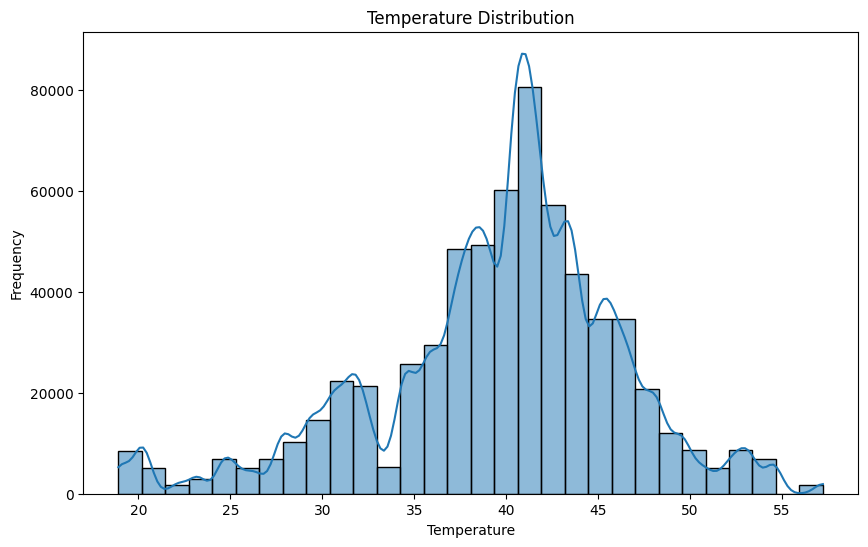

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(df['temperature'], bins=30, kde=True)
plt.title('Temperature Distribution')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

Will be one for the standardscaler. Next one:

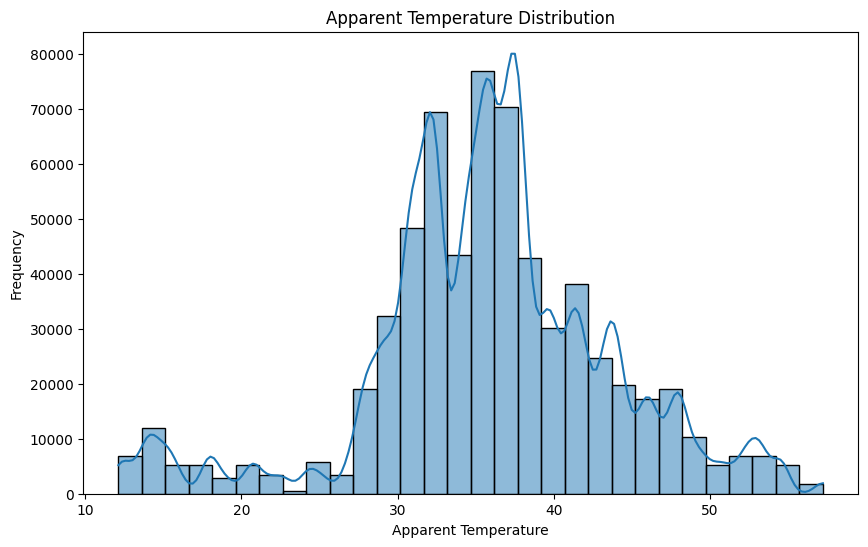

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(df['apparentTemperature'], bins=30, kde=True)
plt.title('Apparent Temperature Distribution')
plt.xlabel('Apparent Temperature')
plt.ylabel('Frequency')
plt.show()

Same story, but I'm wondering if this would not be too much correlated with [temperature]?

In [21]:
df[['temperature', 'apparentTemperature']].corr()

,temperature,apparentTemperature
temperature,1.000000,0.946157
apparentTemperature,0.946157,1.000000


Really high correlation, so I will drop this one.

In [22]:
df = df.drop('apparentTemperature', axis=1)

Next one: precipIntensity

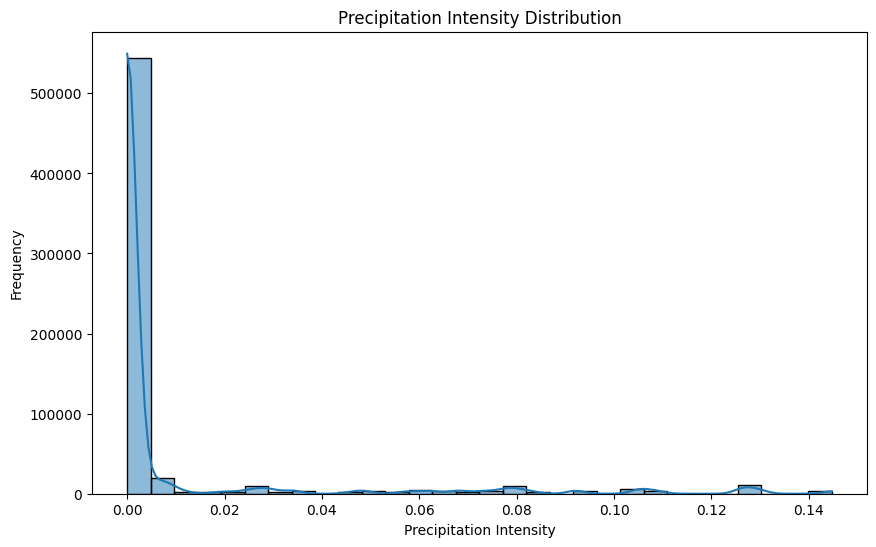

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(df['precipIntensity'], bins=30, kde=True)
plt.title('Precipitation Intensity Distribution')
plt.xlabel('Precipitation Intensity')
plt.ylabel('Frequency')
plt.show()

This looks rather then a yes or no question, so I wil make it binary and turn it into an object

In [27]:
df['precipIntensity'] = (df['precipIntensity'] > 0).astype(str)

for [apparentTemperatureLow] I already got the idea that it will be also too correlated...

In [30]:
df[['apparentTemperatureLow', 'temperature']].corr()

,apparentTemperatureLow,temperature
apparentTemperatureLow,1.000000,0.382828
temperature,0.382828,1.000000


Nothing too correlated to worry about, will be standardscaled, but what about with the max?

In [33]:
df[['apparentTemperatureHigh', 'apparentTemperatureLow', 'temperature']].corr()

,apparentTemperatureHigh,apparentTemperatureLow,temperature
apparentTemperatureHigh,1.000000,0.602182,0.710386
apparentTemperatureLow,0.602182,1.000000,0.382828
temperature,0.710386,0.382828,1.000000


It seems that it would correlate too much with [temperature] and [temperaturelow], so I will drop the [apparentTemeratureHigh]

In [35]:
df = df.drop(['apparentTemperatureHigh'], axis=1)

Next histogram for [uvIndexTime]

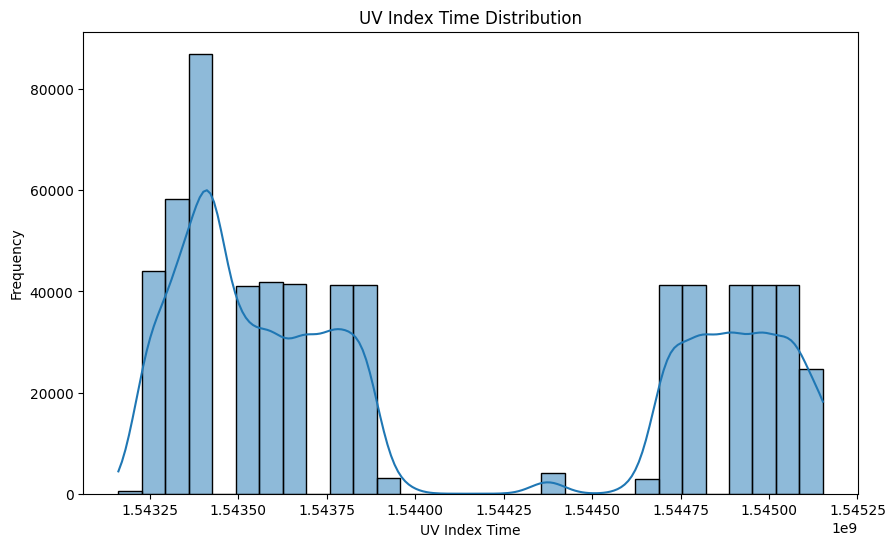

In [37]:
plt.figure(figsize=(10, 6))
sns.histplot(df['uvIndexTime'], bins=30, kde=True)
plt.title('UV Index Time Distribution')
plt.xlabel('UV Index Time')
plt.ylabel('Frequency')
plt.show()

UV doesn't look like an important factor to me to feature-engineer it from the timestamps, especially since this is all for months November and December and I cannot imagine that UV-index will have an impact. I could be wrong, but I'm taking the risk :)

In [40]:
df = df.drop('uvIndexTime', axis=1)

For [temperatureMin] I will be directly checking for high correlations.

In [41]:
df[['temperatureMin', 'temperatureMax', 'temperature']].corr()

,temperatureMin,temperatureMax,temperature
temperatureMin,1.000000,0.782981,0.789220
temperatureMax,0.782981,1.000000,0.780426
temperature,0.789220,0.780426,1.000000


I thought so. So [temperatureMin] and [temperatureMax] will be dropped!

In [42]:
df = df.drop(['temperatureMin', 'temperatureMax'], axis=1)

Next: [temperatureMinTime]

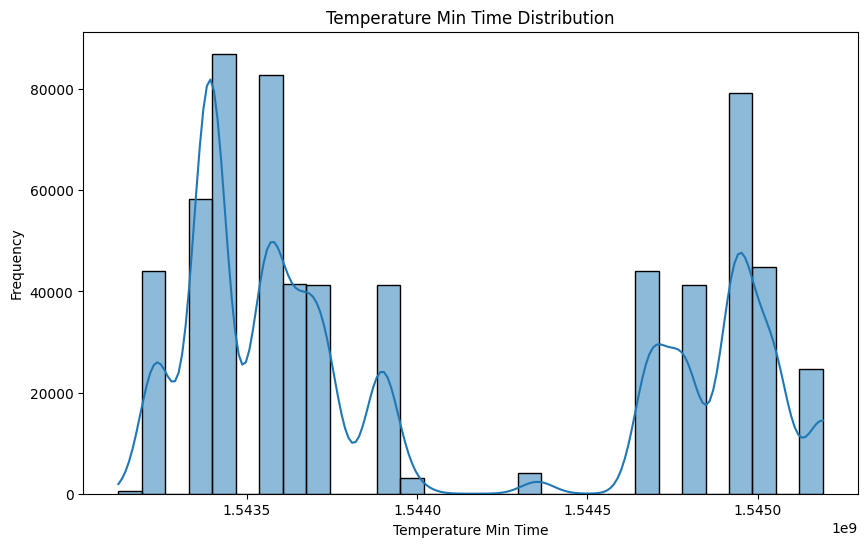

In [43]:
plt.figure(figsize=(10, 6))
sns.histplot(df['temperatureMinTime'], bins=30, kde=True)
plt.title('Temperature Min Time Distribution')
plt.xlabel('Temperature Min Time')
plt.ylabel('Frequency')
plt.show()

I can be wrong, but I will not be testing the specific moments for min and max temperature times, and it would be the same for the "apperent", so dropping this one and the rest! Will get back to it if needed lol.

In [ ]:
df = df.drop(columns=[
    'windGustTime', 
    'temperatureHigh', 
    'temperatureHighTime', 
    'temperatureLow', 
    'temperatureLowTime',
    'apparentTemperatureHighTime',
    'apparentTemperatureLow', 
    'apparentTemperatureLowTime'
    'temperatureMinTime', 
    'temperatureMaxTime', 
    'apparentTemperatureMin',
    'apparentTemperatureMinTime', 
    'apparentTemperatureMax',
    'apparentTemperatureMaxTime'
])

Forgot to scroll up in my txt. Still need to check some of the other ones. Damn, what a journey.

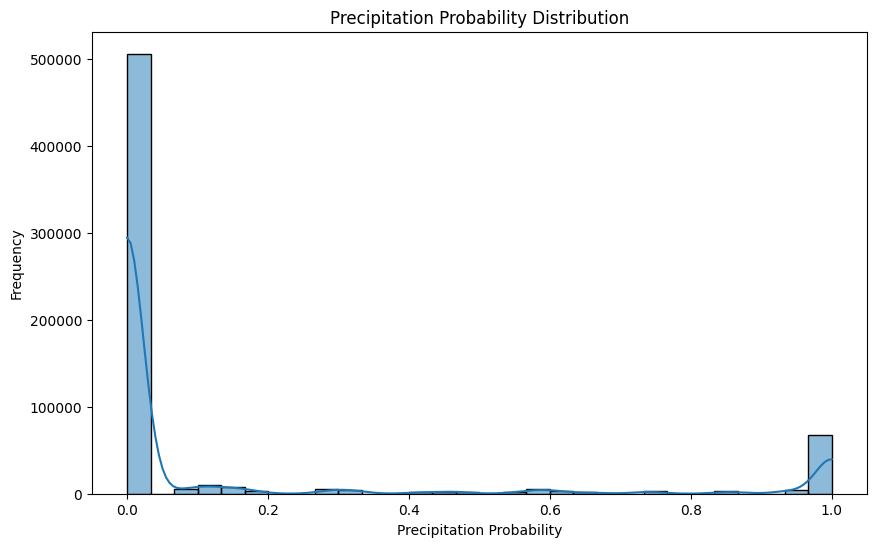

In [51]:
plt.figure(figsize=(10, 6))
sns.histplot(df['precipProbability'], bins=30, kde=True)
plt.title('Precipitation Probability Distribution')
plt.xlabel('Precipitation Probability')
plt.ylabel('Frequency')
plt.show()

Okay, this is a little subjective maybe, but I will make this a category with every chance above 0.5 as yes

In [52]:
df['precipProbability'] = (df['precipProbability'] > 0.5).astype(str)


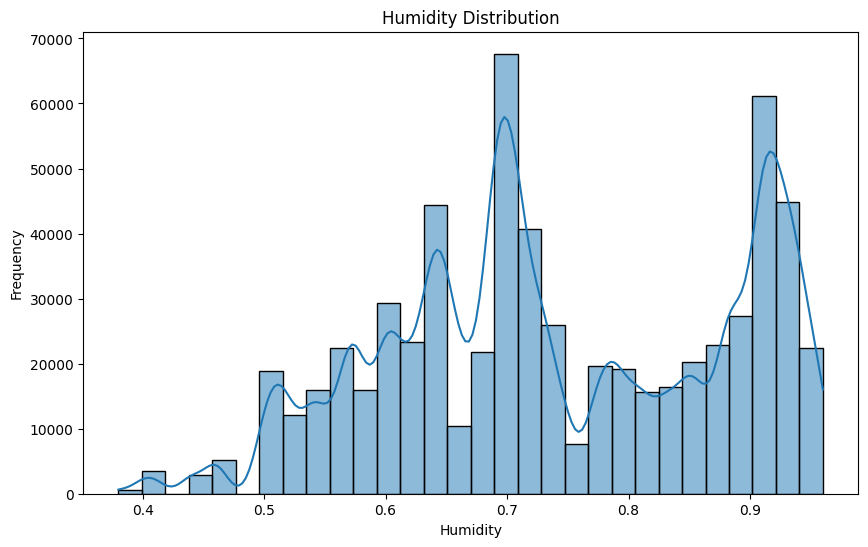

In [53]:
plt.figure(figsize=(10, 6))
sns.histplot(df['humidity'], bins=30, kde=True)
plt.title('Humidity Distribution')
plt.xlabel('Humidity')
plt.ylabel('Frequency')
plt.show()

Okay, this one will be for the standardscaler. Neeeeext.

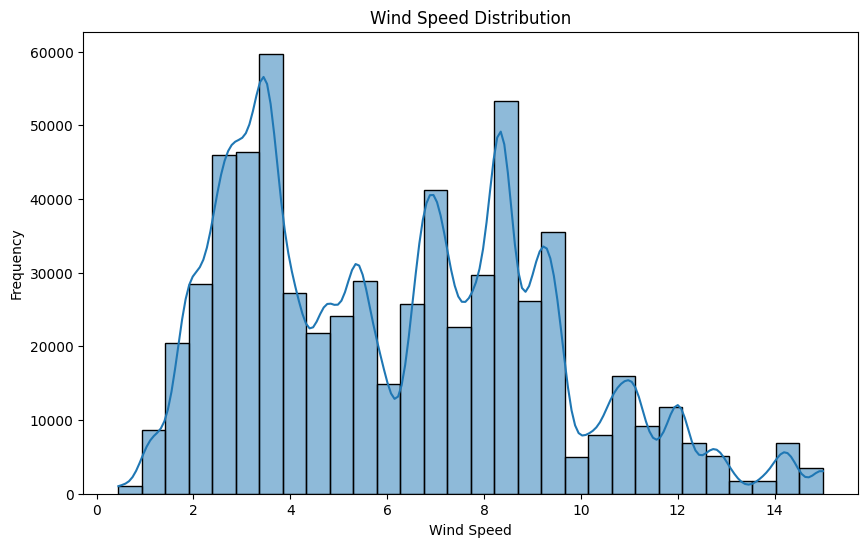

In [54]:
plt.figure(figsize=(10, 6))
sns.histplot(df['windSpeed'], bins=30, kde=True)
plt.title('Wind Speed Distribution')
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.show()

Zelfde verhaal, standardscaler.

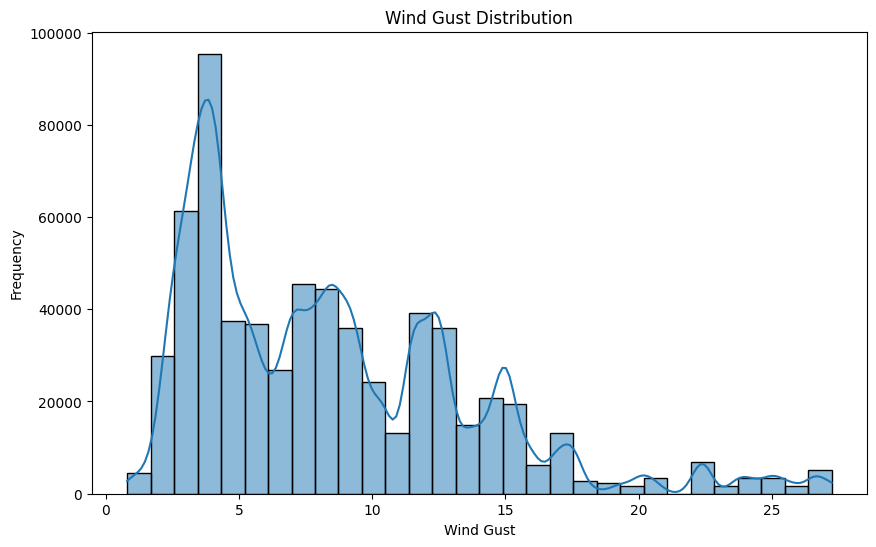

In [55]:
plt.figure(figsize=(10, 6))
sns.histplot(df['windGust'], bins=30, kde=True)
plt.title('Wind Gust Distribution')
plt.xlabel('Wind Gust')
plt.ylabel('Frequency')
plt.show()

Not sure if this is highly correlated with general windspeed, let's check.

In [56]:
df[['windSpeed', 'windGust']].corr()

,windSpeed,windGust
windSpeed,1.000000,0.937649
windGust,0.937649,1.000000


Yes it is, so I will drop [windGust]

In [57]:
df = df.drop('windGust', axis=1)

I cannot imagine that [dewPoint] would be significant in cab prices, but you never know.

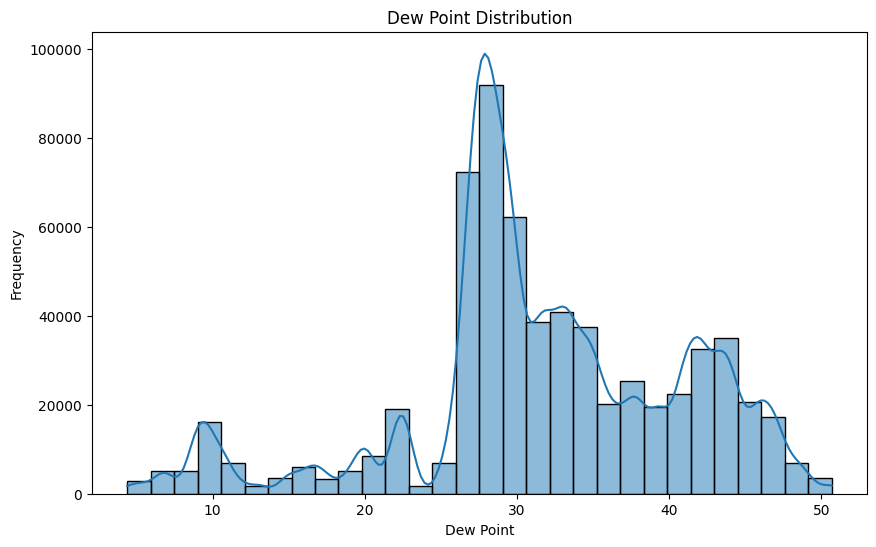

In [58]:
plt.figure(figsize=(10, 6))
sns.histplot(df['dewPoint'], bins=30, kde=True)
plt.title('Dew Point Distribution')
plt.xlabel('Dew Point')
plt.ylabel('Frequency')
plt.show()

I'll put it through standardscaler, can always leave it afterwards.

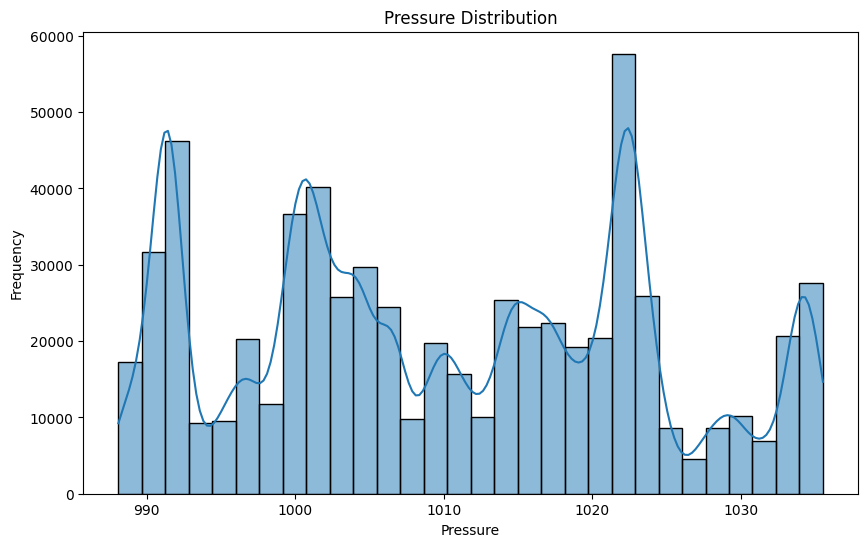

In [59]:
plt.figure(figsize=(10, 6))
sns.histplot(df['pressure'], bins=30, kde=True)
plt.title('Pressure Distribution')
plt.xlabel('Pressure')
plt.ylabel('Frequency')
plt.show()

Hmm, isn't pressure always correlated with temperature? I think that's what I learned when I was a kid. Will check.

In [60]:
df[['pressure', 'temperature']].corr()

,pressure,temperature
pressure,1.000000,-0.339378
temperature,-0.339378,1.000000


Not too high of a correlation I guess, I'll let him pass through standardscaler and will check later on.

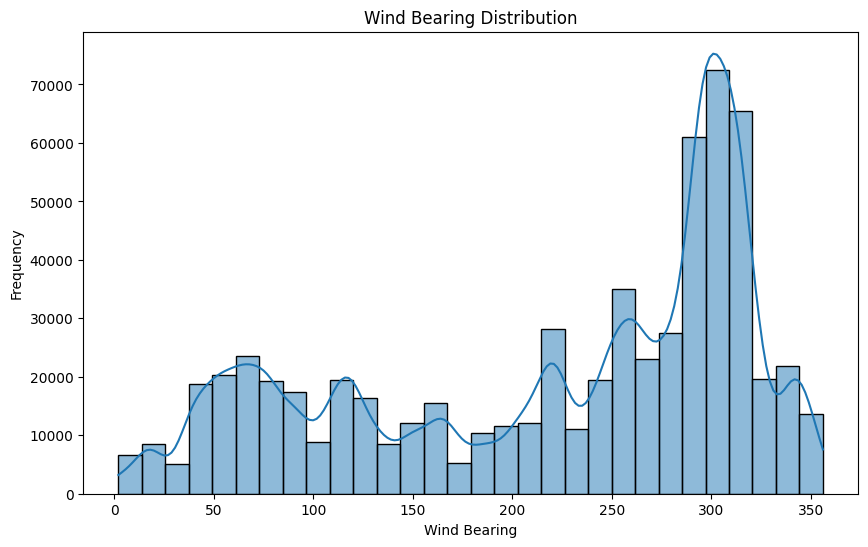

In [61]:
plt.figure(figsize=(10, 6))
sns.histplot(df['windBearing'], bins=30, kde=True)
plt.title('Wind Bearing Distribution')
plt.xlabel('Wind Bearing')
plt.ylabel('Frequency')
plt.show()

I will not accept that the direction of the wind could influence the price, so I will drop this one. 

In [62]:
df = df.drop('windBearing', axis=1)

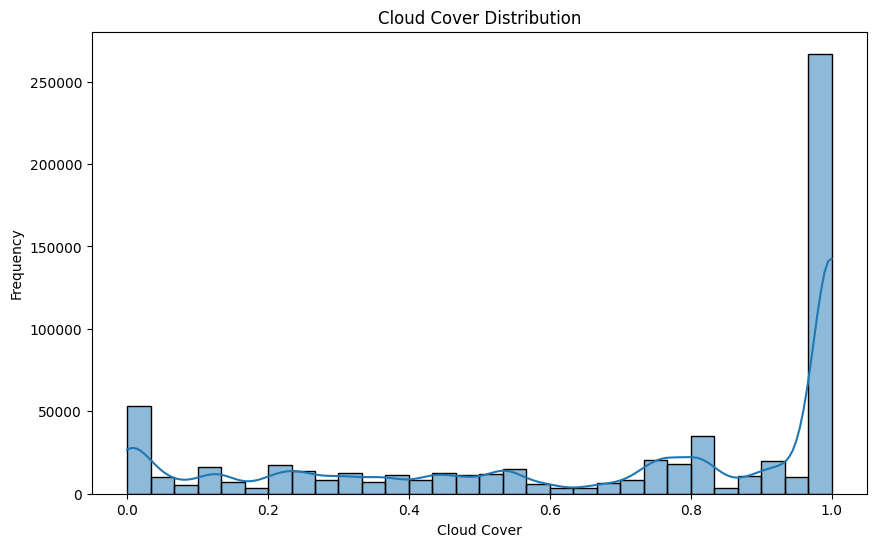

In [63]:
plt.figure(figsize=(10, 6))
sns.histplot(df['cloudCover'], bins=30, kde=True)
plt.title('Cloud Cover Distribution')
plt.xlabel('Cloud Cover')
plt.ylabel('Frequency')
plt.show()

This one is a brainteaser. If it's cloudy, more chance for rain, but we actually got that one in [precipIntensity]... But since it's between 0 and 1, for the sake of the exercise, let's put this trough a min/max scaler.

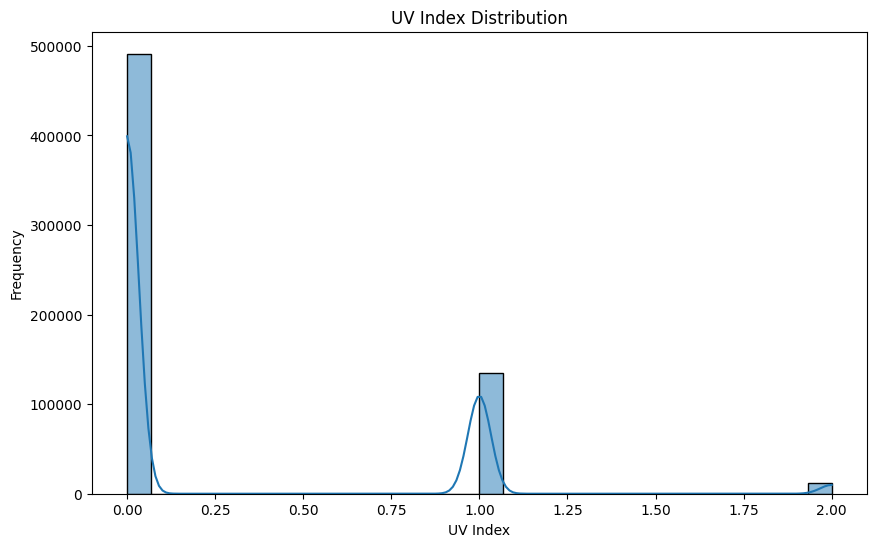

In [64]:
plt.figure(figsize=(10, 6))
sns.histplot(df['uvIndex'], bins=30, kde=True)
plt.title('UV Index Distribution')
plt.xlabel('UV Index')
plt.ylabel('Frequency')
plt.show()

Looks more as a category to me, so I convert it now in an object and then later one it can be one hot encoded.

In [65]:
df['uvIndex'] = df['uvIndex'].astype(str)

Ozone, seriously?

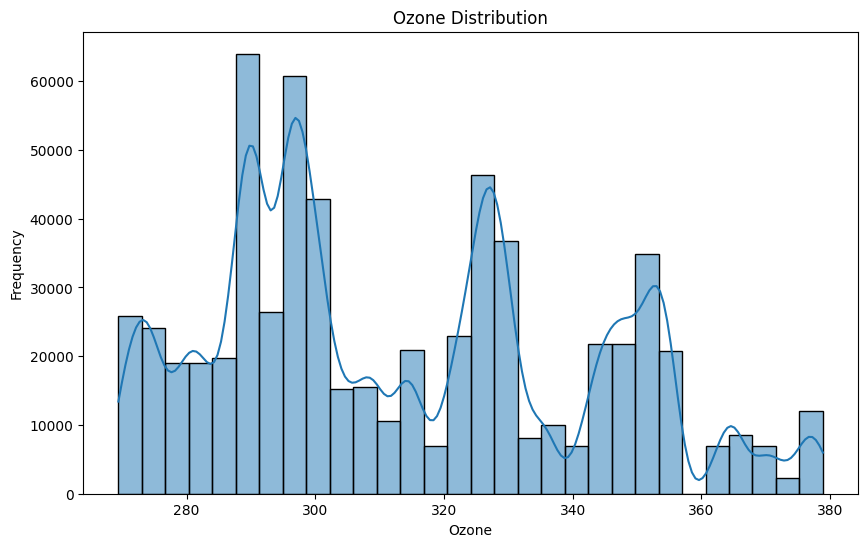

In [66]:
plt.figure(figsize=(10, 6))
sns.histplot(df['ozone'], bins=30, kde=True)
plt.title('Ozone Distribution')
plt.xlabel('Ozone')
plt.ylabel('Frequency')
plt.show()

Cannot imagine it would have a high impact, but let's keep it and let it go through standardscaler.

I really don't care about [sunriseTime] and [sunsetTime] to be honest, they are all around the same in November and December. I'll drop them.

In [67]:
df = df.drop(columns=['sunriseTime', 'sunsetTime'])

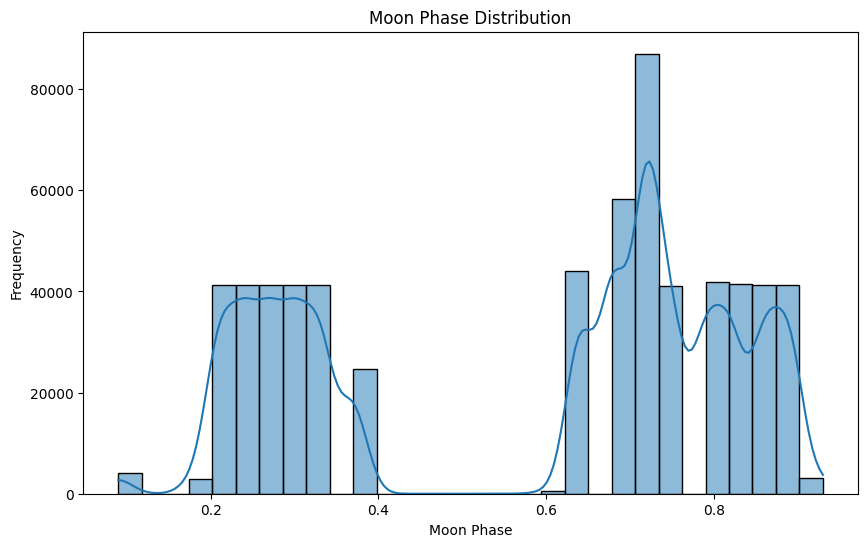

In [68]:
plt.figure(figsize=(10, 6))
sns.histplot(df['moonPhase'], bins=30, kde=True)
plt.title('Moon Phase Distribution')
plt.xlabel('Moon Phase')
plt.ylabel('Frequency')
plt.show()

My experience from the Data Analysis End Project learned me that moonphases can have a spiritual impact, but when not even on accidents, certainly not on cab prices :) Dropping!

In [69]:
df = df.drop('moonPhase', axis=1)

Last one for the numerical ones. I have to optimize my strategies in the future I think. But here we go.

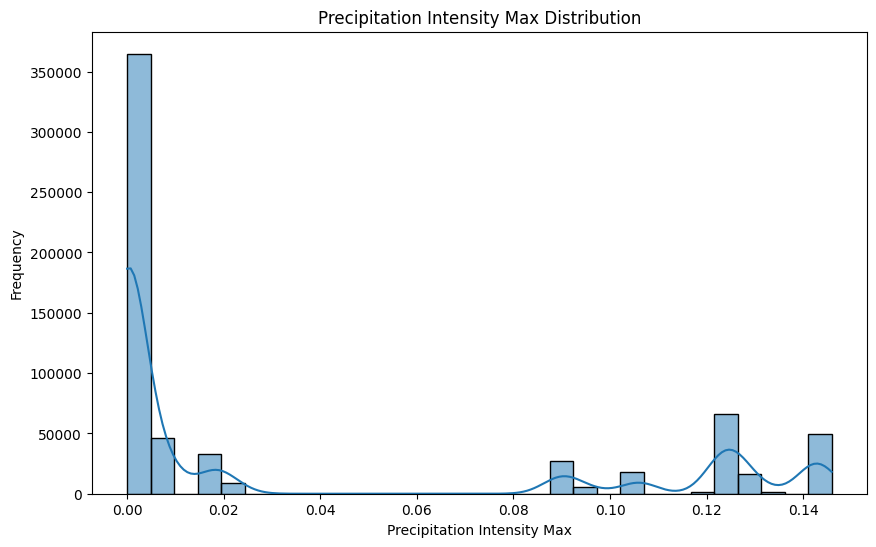

In [70]:
plt.figure(figsize=(10, 6))
sns.histplot(df['precipIntensityMax'], bins=30, kde=True)
plt.title('Precipitation Intensity Max Distribution')
plt.xlabel('Precipitation Intensity Max')
plt.ylabel('Frequency')
plt.show()

Probably highly correlating with precipIntensity, will drop.

In [71]:
df = df.drop('precipIntensityMax', axis=1)

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 637976 entries, 0 to 693070
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   timestamp          637976 non-null  float64       
 1   hour               637976 non-null  int64         
 2   month              637976 non-null  int64         
 3   datetime           637976 non-null  datetime64[ns]
 4   source             637976 non-null  object        
 5   destination        637976 non-null  object        
 6   cab_type           637976 non-null  object        
 7   name               637976 non-null  object        
 8   price              637976 non-null  float64       
 9   distance           637976 non-null  float64       
 10  surge_multiplier   637976 non-null  object        
 11  latitude           637976 non-null  float64       
 12  longitude          637976 non-null  float64       
 13  temperature        637976 non-null  float64      

I will put all the numeric features in num_features

In [75]:
num_features = df.select_dtypes(include=[np.number]).columns
print(num_features)

Index(['timestamp', 'hour', 'month', 'price', 'distance', 'latitude',
       'longitude', 'temperature', 'humidity', 'windSpeed', 'visibility',
       'dewPoint', 'pressure', 'cloudCover', 'ozone', 'day_of_week',
       'price_log'],
      dtype='object')


Shit, I don't think I can do something with a few of those, and other ones need to be categorical too I guess. Sooooo...

In [77]:
num_features = num_features.drop(['timestamp', 'latitude', 'longitude'])

In [83]:
df[['hour', 'month', 'day_of_week']] = df[['hour', 'month', 'day_of_week']].astype(str)

Owwwwwkay, let's check the categorical values now.

In [84]:
cat_features = df.select_dtypes(include=['object']).columns
print(cat_features)

Index(['hour', 'month', 'source', 'destination', 'cab_type', 'name',
       'surge_multiplier', 'short_summary', 'long_summary', 'precipIntensity',
       'precipProbability', 'uvIndex', 'day_of_week'],
      dtype='object')


I already made some of those as an object for the one hot encoding, like [surge_multiplier], [precipIntensity], [precipProbability] and [uvIndex]. So this one can be a quick check. I certainly don't need long summaries when I have short ones. Dropping that one.

In [85]:
cat_features = cat_features.drop('long_summary')

I will put [hour], [month], [source], [destination], [cab_type], [name], [day_of_week] and [short_summary] to be one hot encoded on my list. Let's see again how this looks for now.

In [86]:
print(num_features)
print(cat_features)

Index(['hour', 'month', 'price', 'distance', 'temperature', 'humidity',
       'windSpeed', 'visibility', 'dewPoint', 'pressure', 'cloudCover',
       'ozone', 'day_of_week', 'price_log'],
      dtype='object')
Index(['hour', 'month', 'source', 'destination', 'cab_type', 'name',
       'surge_multiplier', 'short_summary', 'precipIntensity',
       'precipProbability', 'uvIndex', 'day_of_week'],
      dtype='object')


Owkay, not in the right order I guess.

In [88]:
num_features = num_features.drop(['hour', 'month', 'day_of_week'])

In [91]:
df = df[list(num_features) + list(cat_features)]

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 637976 entries, 0 to 693070
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              637976 non-null  float64
 1   distance           637976 non-null  float64
 2   temperature        637976 non-null  float64
 3   humidity           637976 non-null  float64
 4   windSpeed          637976 non-null  float64
 5   visibility         637976 non-null  float64
 6   dewPoint           637976 non-null  float64
 7   pressure           637976 non-null  float64
 8   cloudCover         637976 non-null  float64
 9   ozone              637976 non-null  float64
 10  price_log          637976 non-null  float64
 11  hour               637976 non-null  object 
 12  month              637976 non-null  object 
 13  source             637976 non-null  object 
 14  destination        637976 non-null  object 
 15  cab_type           637976 non-null  object 
 16  name   

We are finally on our way to make a pipeline and split the shit!

In [94]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

num_features = ['distance', 'temperature', 'humidity', 'windSpeed', 'dewPoint', 'pressure', 'ozone']
minmax_features = ['cloudCover']
cat_features = ['hour', 'month', 'source', 'destination', 'cab_type', 'name', 'surge_multiplier', 
                'short_summary', 'precipIntensity', 'precipProbability', 'uvIndex', 'day_of_week']

num_transformer = StandardScaler()
minmax_transformer = MinMaxScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('minmax', minmax_transformer, minmax_features),
    ('cat', cat_transformer, cat_features)
])

X = df.drop(columns=['price', 'price_log'])
y = df['price_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


## Let's. Do. This.

In [96]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()

model.fit(X_train_transformed, y_train)

y_pred = model.predict(X_test_transformed)

rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"📊 RMSE: {rmse:.4f}")
print(f"📊 R² Score: {r2:.4f}")


📊 RMSE: 0.1259
📊 R² Score: 0.9428


This looks goooooood :)

In [98]:
exp_rmse = np.exp(rmse)
print(f"📊 RMSE without the log: {exp_rmse:.2f}")

📊 RMSE without the log: 1.13
